In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import random
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt

import warnings
import pickle
warnings.filterwarnings("ignore", category=FutureWarning)

import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
from causalgraphicalmodels import CausalGraphicalModel
import daft

In [78]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.0.3
numpy==1.24.2
seaborn==0.12.2
arviz==0.15.1
pymc==5.1.2
daft==0.1.2


# Introduction

This notebook describes and implements the model for estimating paper values and rater estimates on the basis of the ordinal and binary tasks that the reviewers have to complete. Due to a shortage of time (deadline for the use of funding), we could not add more annotations to the code. We will do this ASAP after the preregistration, without altering the code itself.

# Causal assumptions: Directed Acyclic Graph



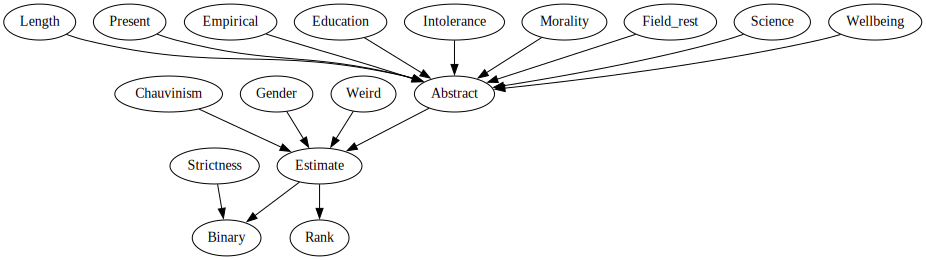

In [3]:
IIH_dag = CausalGraphicalModel(
    nodes=["Binary", "Rank",
            "Estimate", "Abstract", 
           "Morality", "Present",'Empirical','Intolerance','Education','Wellbeing','Science','Field_rest',
           'Chauvinism','Strictness', 'Length','Gender','Weird'], edges=[
        
        ("Field_rest", "Abstract"),
        ("Morality", "Abstract"),
        ("Present", "Abstract"),
        ("Empirical", "Abstract"),
        ("Intolerance", "Abstract"),
        ("Education", "Abstract"),
        ("Wellbeing", "Abstract"),
        ("Science", "Abstract"),
        ("Abstract", "Estimate"),
        ("Estimate", "Binary"),       
        ('Estimate','Rank'),
        ('Chauvinism','Estimate'),
        ('Strictness','Binary'),
        ('Length','Abstract'),
        ('Gender','Estimate'),
        ('Weird','Estimate')
    ]
)


IIH_dag.draw()


# Data

In [3]:
## get data and sort in the right order
## data wrangling is described in XXX

df = pd.read_csv('...')
df = df.drop(['Unnamed: 0'], axis=1)

# Pilot study had two groups, select here which group

df = df.loc[df.group == 'group1']

# put in the order that the model assumes they are in
df = df.sort_values(by = ['block','field','rater'])

# dtype should be categorical

cat_cols = ['block', 'field', 'rater', 'binary', 'abstract','ordinal', 
            'rater_disc', 'doctype', 'group','chauvinism']

df[cat_cols] = df[cat_cols].astype('category')



In [4]:
print(f'number of ratings: {len(df)}')
df.head(3)

number of ratings: 3105


,block,field,rater,binary,abstract,ordinal,rater_disc,pubyear,doi,doctype,...,Ethics,Empirical,Environment,Education,Wellbeing,B3_L,abstract_text,title,abstract_length,abstract_wordcount
136,10,HIST,111.0,1.0,QID10_1,3.0,PHIL,2016.0,10.1080/10412573.2016.1178450,Article,...,0.0,0.0,0.0,0.0,0.0,0.0,"Lucy Hutchinson's ""Elegies,"" which were writte...","Gardens of Grief: Lucy Hutchinson's ""Elegies,""...",1021,151
135,10,HIST,121.0,0.0,QID10_1,1.0,PHIL,2016.0,10.1080/10412573.2016.1178450,Article,...,0.0,0.0,0.0,0.0,0.0,0.0,"Lucy Hutchinson's ""Elegies,"" which were writte...","Gardens of Grief: Lucy Hutchinson's ""Elegies,""...",1021,151
129,10,HIST,142.0,0.0,QID10_1,1.0,PHIL,2016.0,10.1080/10412573.2016.1178450,Article,...,0.0,0.0,0.0,0.0,0.0,0.0,"Lucy Hutchinson's ""Elegies,"" which were writte...","Gardens of Grief: Lucy Hutchinson's ""Elegies,""...",1021,151


In [5]:
### Indices and dimensions for the model

## Indices for data on the rating-level (i.e. each row is a rating)

block_idx = df.block.cat.codes.values
field_idx = df.field.cat.codes.values
rater_idx = df.rater.cat.codes.values
binary_idx = df.binary.cat.codes.values
abstract_idx = df.abstract.cat.codes.values
chauvinism_idx = df.chauvinism.cat.codes.values

# The categories of these variables
block_codes = df.block.cat.categories.values
field_codes = df.field.cat.categories.values
rater_codes = df.rater.cat.categories.values
abstract_codes = df.abstract.cat.categories.values
chauvinism_codes = df.chauvinism.cat.categories.values


## Indices, data and dimensions needed for the causes data (i.e. each row is an abstract)

# reduce the df to one row for each abstract by taking the data for one rater
# this is for the data on the paper-level (i.e. the causes and fields)

random_rater = rater_codes[0]
df_short = df.loc[(df.rater == random_rater)].copy()

# make categorical

cat_cols = ['block', 'field', 'rater', 'binary', 'abstract',
           'ordinal', 'rater_disc', 'doctype', 'group',
           'chauvinism']

df_short[cat_cols] = df_short[cat_cols].astype('category')

# abstract length XXX
# df_short['length_norm'] = (df_short.abstract_length - df_short.abstract_length.mean()) / df_short.abstract_length.std()

causes_codes = ['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing'] #,'Length'
causes_data = df_short[['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing']].values.T #,'length_norm'

# Indices on this level
abstract_field_idx = df_short.field.cat.codes.values

# dimensions for the pymc3 model
coords = {'b_n': block_codes, 'f_n':field_codes, 'r_n':rater_codes,'a_n':abstract_codes,
          'c_n':chauvinism_codes, 'caus_n':causes_codes}

## for the shapes of the arrays

n_discs = 5
n = len(block_codes)
r = len(rater_codes)

In [6]:
## The model needs the data in a particular form (y_argsort),
## and needs an array for indexing to make it work with the 3d structure (i_array)

# get a df with on each row the ordinal scores of one rating (hence n_raters * n_blocks rows)

ordinal_scores = (df[['block','ordinal','field','rater']].pivot(
    index=['block','rater'], 
    columns=['field'], 
    values=['ordinal'])['ordinal'].reset_index()[['HIST','LING','LIT','PHIL','REL']])

# now change the shape of the array such that there is row for each field,
# and the first score in that row is the ordinal score of the first rater, the second of the second rater, etc.
# also, put each block in a separate array
# hence, the shape of this array is (n_blocks, n_fields, n_raters)

reshaped_ratings = np.array([
    list(ordinal_scores.values.reshape((n, r, 5))[i].T)
    for i in range(n)
])

# now argsort them as this is how we need them in the model
y_argsort = np.argsort(reshaped_ratings, axis = 1)

## arrays for indexing in the model

# first for getting from the paper_value to the rater_estimate

i_array1 = np.array([[list(np.repeat(i, r))]*5 for i in range(n)])

# then later for transposing the rater_estimate back in the right shape before flattening it for the bernoulli

i_array2 = np.transpose(y_argsort,(0,2,1)).argsort(2)


In [7]:
"""
The ordinal data we feed in the model are arrays of (5 ranks, n_raters for each block, n_blocks in total).
To have a chauvinism parameter work in this 3D structure, we need an array indexing where in these 3D  arrays of 5 scores
the values are that were given by a rater of the same field as the abstract.

"""

# make an array (rater_discs_array) with the index of each rater's field in the array of fields (df.field.unique())


oneabstract = df.loc[(df.block == block_codes[0]) & (df.abstract == abstract_codes[0])]
rater_discs = {oneabstract['rater'].values[i]:oneabstract['rater_disc'].values[i] for i in range(r)}
field_dct = {list(df.field.unique())[i]:i for i in range(n_discs)}
rater_discs_array = np.array([field_dct[i] for i in rater_discs.values()])

# make array with only zeros for one block, with one row per rater
chauv_array = np.zeros((r,n_discs))

# now set the value in this array to 1 if the rater field and abstract field match (possible because fixed order of fields in this shape)

for i in range(r):
    chauv_array[i,rater_discs_array[i]] = 1 
    
# then multiply it by n to get one for each block

chauv_array_full = np.concatenate([chauv_array]*n)

# now get the ordinal scores (one row per rating) and argsort them


    
ranked_argsort = np.argsort(ordinal_scores.values)

# for each rating, get the array with the index of the chauvinism (always has one 1 if the raters are all from humanities)
# for each rating, also get the array with the argsorted ordinal scores
# then index latter with the former, this tells you which position in the argsorted rank got influenced by chauvinism

rating_rows = []
for i in range((r * n)):
    chauv_index = ranked_argsort[i]
    arg_scores = chauv_array_full[i]
    arg_pos = arg_scores[chauv_index]
    rating_rows.append(arg_pos)

chauv_array_full = np.array(rating_rows)

# now reshape them as above to get them with in the correct 3D shape:
# all scores for one abstract in one row, and each column is a rater

chauv_array = np.array([
    list(chauv_array_full.reshape((n,r,n_discs))[i].T) 
    for i in range(n)])

# The model

## Formal notation

<u>*Likelihood:*</u>

Binary<sub>i</sub> ~ Bernoulli(p<sub>i</sub>)


<u>*Deterministic:*</u>

logit(p<sub>i</sub>) = Rater_estimate<sub>abstract[i],rater[i]</sub> + Strictness<sub>rater[i]</sub> 

Causes_lm<sub>j</sub> = Field<sub>[j]</sub> + Morality<sub>[j]</sub> + ...

Est<sub>i</sub> = Paper_value<sub>[i]</sub> + Chauvinism<sub>[i]</sub>


<u>*Fixed Priors:*</u>

Causes ~ Normal(0,1)   ---  (*one for each cause*)

Field<sub>field</sub> ~ Normal(0,1)  ---   (*one for each field*)

Field_sigma ~ HalfNormal(2)  ---   (*one for each field*)

Strictness<sub>rater</sub> ~ Normal(0,1)   ---  (*one for each rater*)

Chauvinism<sub>rater</sub> ~ Normal(0,1)  ---   (*one for each rater*)



<u>*Varying Priors:*</u>

Paper_value<sub>paper</sub> ~ Normal(Causes_lm<sub>block,field</sub>, Field_sigma<sub>field</sub>)  ---   (*one for each paper*)

Rater_estimate ~ Normal(Est<sub>block,field,rater</sub>, 1)  ---   (*one for each estimate*)

Note: Rater_estimate estimated with forced order within block.
   

## Kruschke style visualization of the model

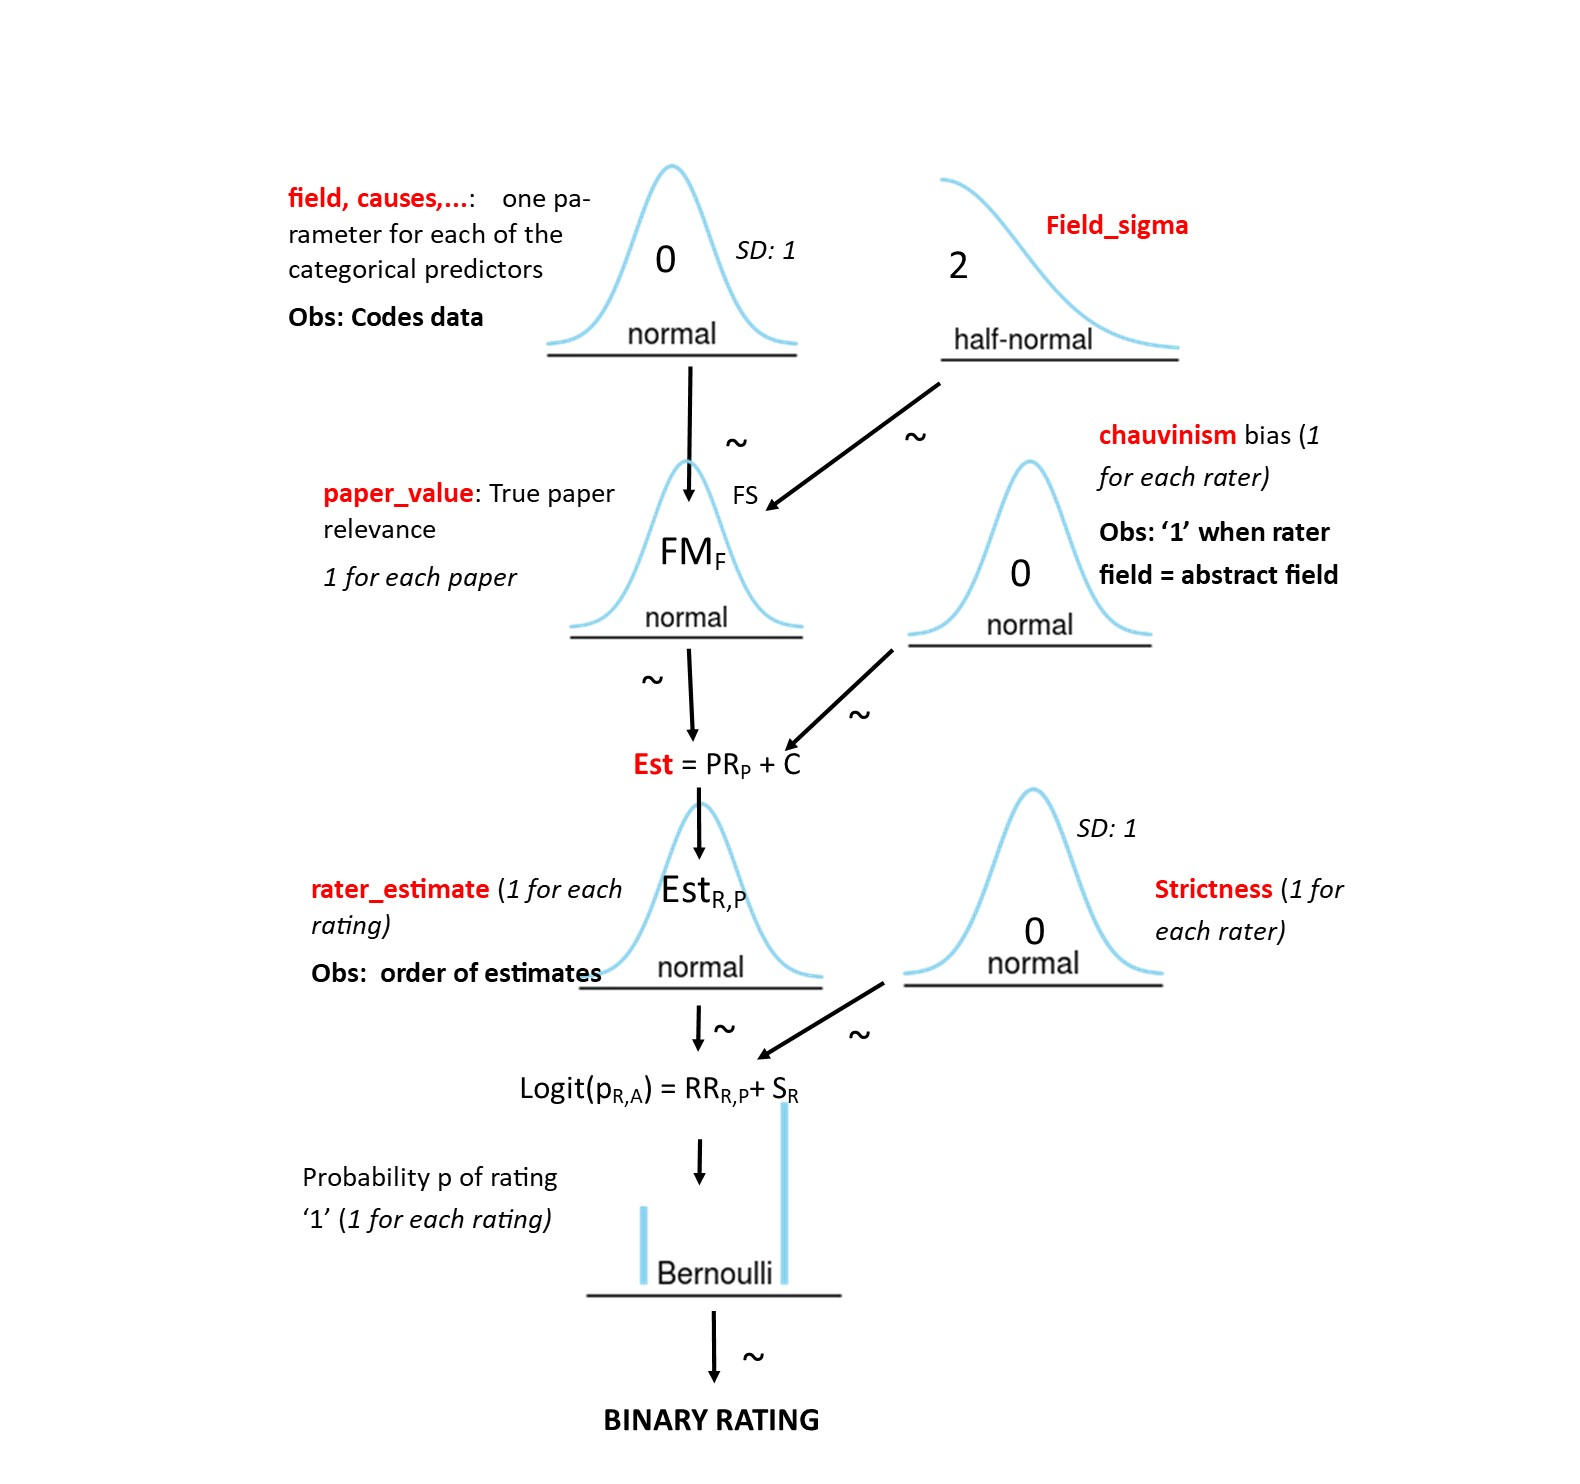

## Implementation

In [5]:
# function to make the ordered transform from pymc work on 3D arrays
# this is based on the source code, and slightly adapted to use the transform in this particular case

from pymc.logprob.transforms import (RVTransform)

class Ordered3D(RVTransform):
    name = "ordered"
    
    def backward(self, value, *inputs):
        x = pt.zeros(value.shape)
        x = pt.inc_subtensor(x[:,0,:], value[:,0,:])
        x = pt.inc_subtensor(x[:,1:,:], pt.exp(value[:,1:,:]))
        return pt.cumsum(x, axis =1)
    
    
    def forward(self, value, *inputs):
        y = pt.zeros(value.shape)
        y = pt.inc_subtensor(y[:,0,:], value[:,0,:])
        y = pt.inc_subtensor(y[:,1:,:], pt.log(value[:,1:,:] - value[:,:-1,:]))
        return y
    
    def log_jac_det(self, value, *inputs):
        return pt.sum(value[:,1:,:], axis=1, keepdims=True)

In [8]:
# the model
    
with pm.Model(coords=coords) as m:

# data

BLOCK = pm.MutableData('BLOCK', block_idx)
RATER = pm.MutableData('RATER', rater_idx)
ABS = pm.MutableData('ABS',abstract_idx)
CAUSES = pm.MutableData('CAUSES',causes_data)
FIELD = pm.MutableData("FIELD", abstract_field_idx)

CHAUV_DATA = pm.MutableData('CHAUV_DATA', chauv_array)


# Linear model with the causes, and an intercept that varies by field
# causes don't vary by field, i.e. we assume that 'ethics' has the same influence across fields, but that some fields have more such papers than others
# this linear model will serve as the hyperprior for the paper_values
# this way we pool information withing papers, and we simultaneously get an estimate for the influence of the causes

causes = pm.Normal('causes',0,1,dims = 'caus_n')
field = pm.Normal("field",0,1, dims = 'f_n')
causes_lm = field[FIELD] + pt.dot(causes,CAUSES)

# reshape the linear model from one row per abstract to (n_blocks, n_discs), such that there is a row for each block
# put this in a deterministic so that we can access it more easily later and get estimates for the field
# if we average over the second dimension, we'll get average estimates for each field

causes_lm_reshaped = pm.Deterministic('causes_lm_reshaped', causes_lm.reshape((n,n_discs)), dims = ('b_n','f_n'))

# hyperprior that will estimate the variance in each of the fields
field_sigma = pm.HalfNormal('field_sigma',2, dims = 'f_n')

# hyperprior for each paper
# this will serve as the prior for all estimates of that particular paper

paper_value = pm.Normal('paper_value',causes_lm_reshaped, field_sigma, dims=('b_n', 'f_n'))


 # Chauvinism varies by rater, and feeds into the rater estimate (along with the paper prior)

chauvinism = pm.Normal('chauvinism',0,1, dims = 'r_n')

 # estimate the 'implicit value estimate' that we assume raters have for each abstract  

rater_estimate = pm.Normal('rater_estimate',
                   mu = paper_value[i_array1,y_argsort] + CHAUV_DATA*chauvinism,
                   sigma = 1, # for some reason, I cannot get it to work with a hyperprior for sigma 
                   transform=Ordered3D(), 
                   shape = (n,n_discs,r),
                   testval=np.array([np.repeat(np.arange(n_discs)[:,None], r, axis=1)]*n))                           

# now change the shape of the rater_estimate (currently shape (n_blocks, n_discs, n_raters))
# Ultimately, it has to be become a 1D array, in the same order as the df (i.e. ordered by block, field, rater)

transposed_rater_estimate0 = pt.transpose(rater_estimate,(0,2,1))
transposed_rater_estimate = pm.Deterministic('transposed_rater_estimate',
                                   pt.transpose(pt.take_along_axis(transposed_rater_estimate0, i_array2,2),(0,2,1)),
                                  dims=('b_n','f_n','r_n'))


transposed_rater_estimate_flat = pt.flatten(transposed_rater_estimate)


# parameter for the strictness of the raters, i.e. how valuable a paper has to be to get a '1'

strictness = pm.Normal('strictness', 0,1, dims = 'r_n')

# likelihood for the binary score, feeding int the rater estimate and the strictness

y = pm.Bernoulli('y', logit_p = transposed_rater_estimate_flat[ABS] + strictness[RATER], observed = binary_idx)

#     # sample from the priors to check them

pr = pm.sample_prior_predictive()

Sampling: [causes, chauvinism, field, field_sigma, paper_value, rater_estimate, strictness, y]


## Sampling

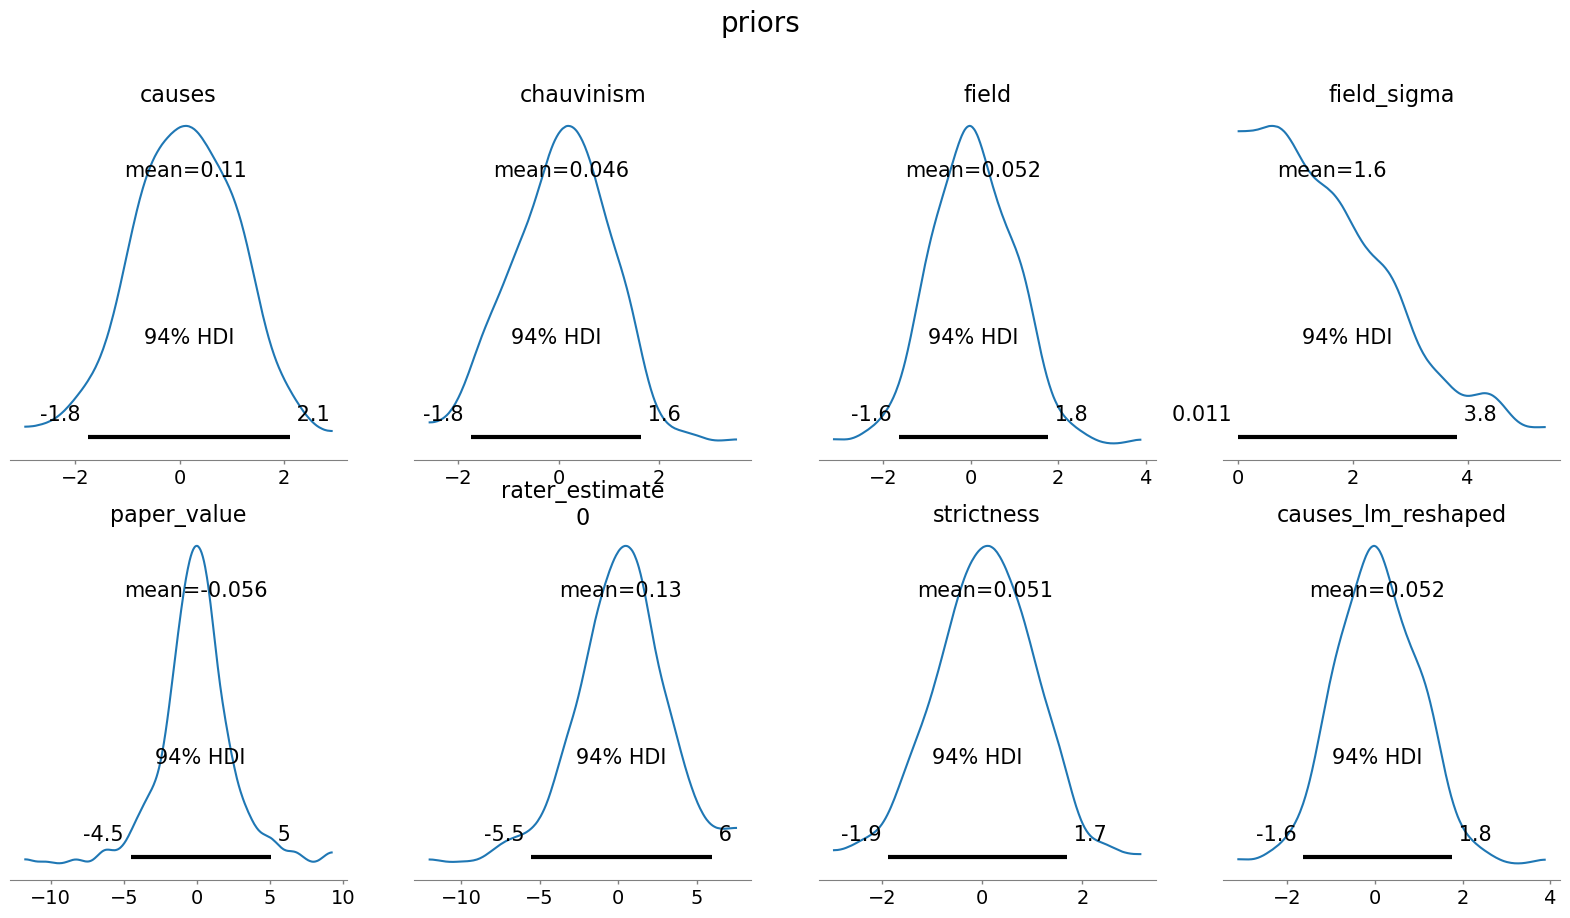

In [26]:
# check priors

fig, axs = plt.subplots(2,4, figsize = (20,10))

for ax, para in zip(axs.flat, ['causes', 'chauvinism','field','field_sigma','paper_value','rater_estimate','strictness','causes_lm_reshaped']):
    if len(pr.prior[para].shape) == 3:
        az.plot_posterior(pr.prior[para][:,:,0], ax=ax)
    elif len(pr.prior[para].shape) == 2:
        az.plot_posterior(pr.prior[para],ax=ax)
    else:
        az.plot_posterior(pr.prior[para][:,:,1,0],ax=ax)
plt.suptitle('priors', fontsize = 20) 

plt.show()
fig.tight_layout()

In [771]:
# sample from the posterior

with m:
    trace_test = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [causes, field, field_sigma, paper_value, chauvinism, rater_estimate, strictness]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 2115 seconds.


In [6]:
# save trace here, or load trace here
# the trace used for the analysis will be uploaded on the OSF page

# trace_test.to_netcdf("...")
# trace_test = az.from_netcdf("...")

In [29]:
# get posterior predictive samples

with m:
    trace_ppc = pm.sample_posterior_predictive(trace_test, var_names = ['y','causes_lm_reshaped','causes', 'chauvinism','field','paper_value','strictness','rater_estimate'])

Sampling: [causes, chauvinism, field, paper_value, rater_estimate, strictness, y]


# Results



## Quick look at model parameters

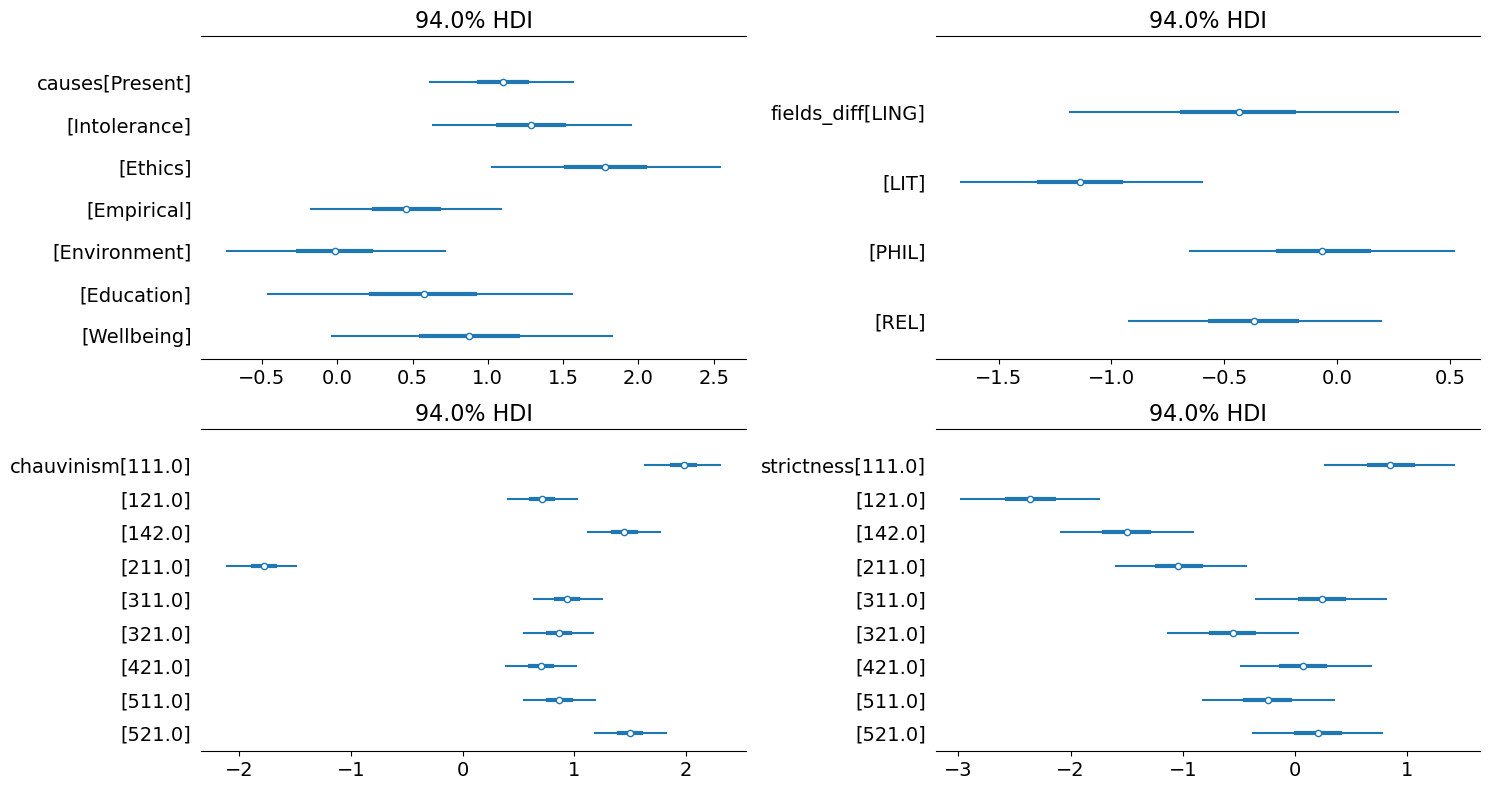

In [10]:
fig, ax = plt.subplots(2,2, figsize = (15,8))

az.plot_forest(trace_test, var_names = ['causes'], combined = True, ax=ax[0,0])

# create a variable for the difference between history and other fields causes parameter

trace_test.posterior["fields_diff"] = trace_test.posterior.field[:,:,1:].rename(f_n = 'f_n_bis') - trace_test.posterior.field[:,:,0]
az.plot_forest(trace_test, var_names = 'fields_diff', combined = True, ax = ax[0,1])

az.plot_forest(trace_test, var_names = 'chauvinism', combined = True, ax=ax[1,0])

az.plot_forest(trace_test, var_names = 'strictness', combined = True, ax = ax[1,1])

fig.tight_layout()

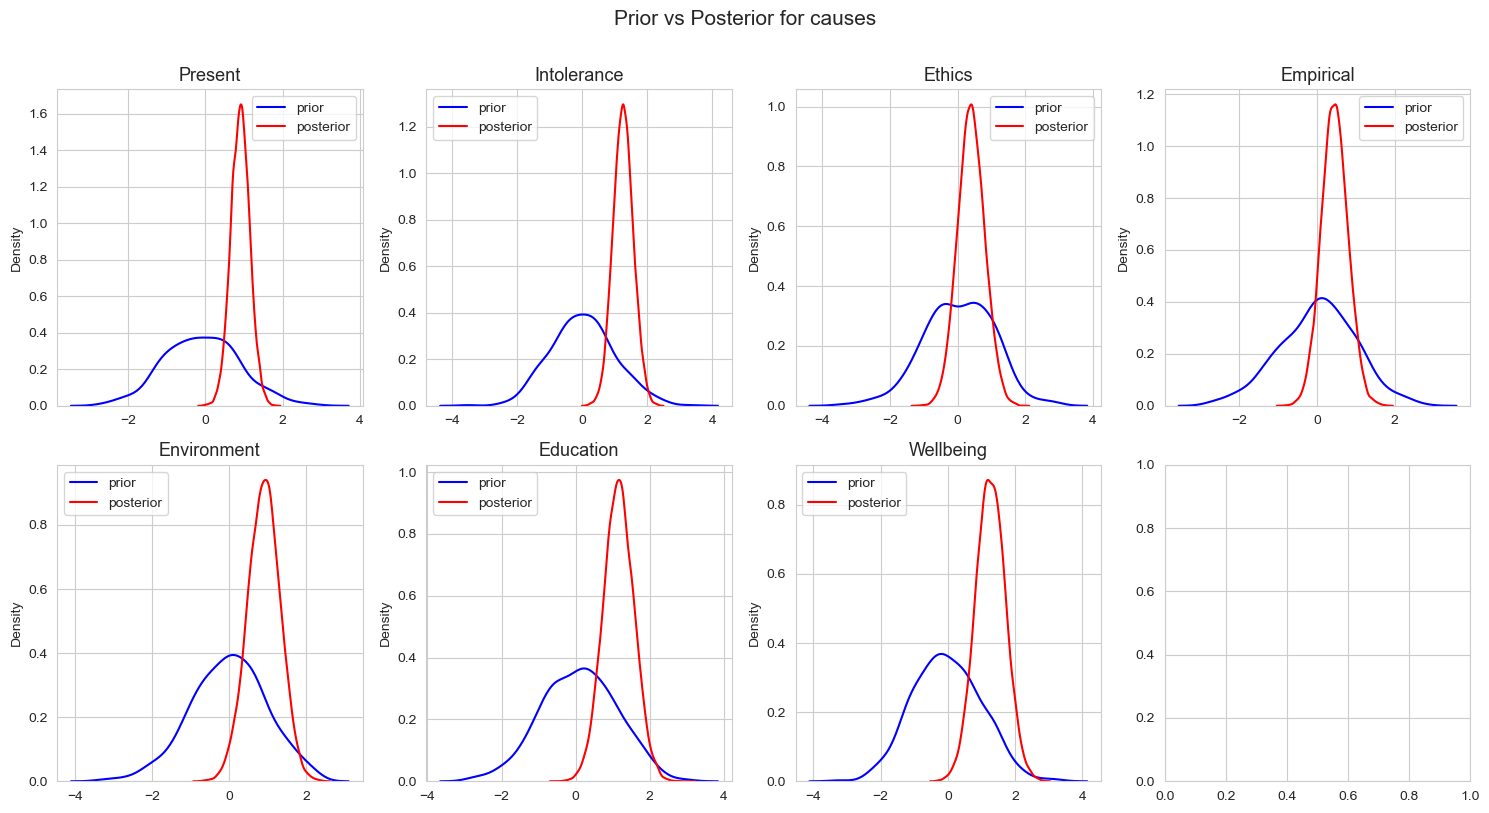

In [776]:
# Posteriors over priors: causes
fig, axs = plt.subplots(2,4, figsize = (15,8))

for ax,i in zip(axs.flat,range(len(causes_codes))):
    sns.kdeplot(np.ravel(pr.prior['causes'][:,:,i].values),color = 'blue', ax=ax)
    sns.kdeplot(np.ravel(trace_test.posterior['causes'][:,:,i].values),color = 'red', ax=ax)
    ax.set_title(causes_codes[i], fontsize = 13)
    ax.legend(['prior','posterior'])
    
plt.suptitle('Prior vs Posterior for causes', fontsize = 15, y = 1.01)
fig.tight_layout()

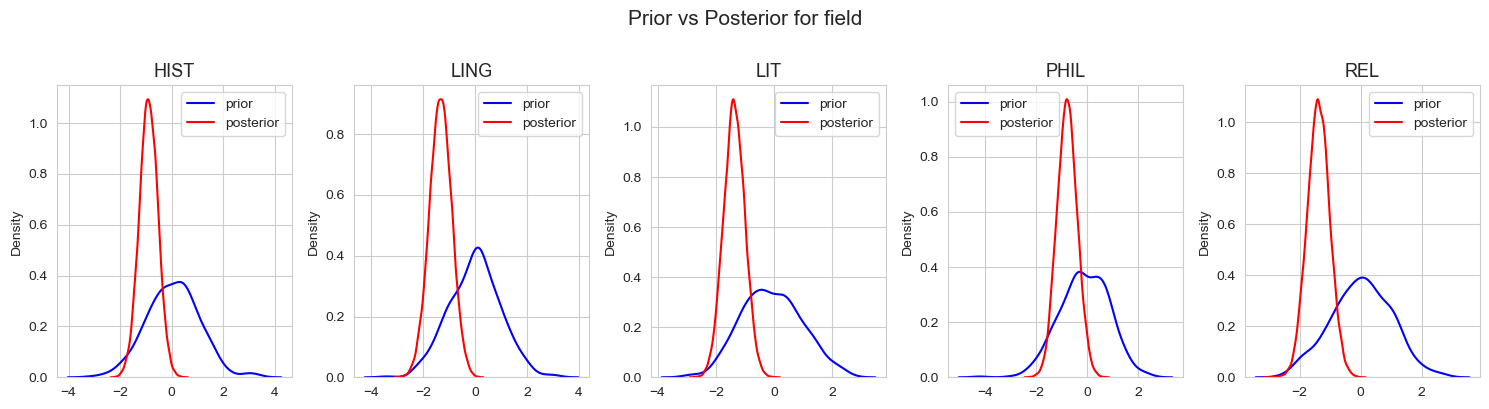

In [777]:
# Posteriors over priors: field
fig, axs = plt.subplots(ncols = 5, figsize = (15,4))

for ax,i in zip(axs.flat,range(len(field_codes))):
    sns.kdeplot(np.ravel(pr.prior['field'][:,:,i].values),color = 'blue', ax=ax)
    sns.kdeplot(np.ravel(trace_test.posterior['field'][:,:,i].values),color = 'red', ax=ax)
    ax.set_title(field_codes[i], fontsize = 13)
    ax.legend(['prior','posterior'])
    
plt.suptitle('Prior vs Posterior for field', fontsize = 15, y = 1.01)
fig.tight_layout()

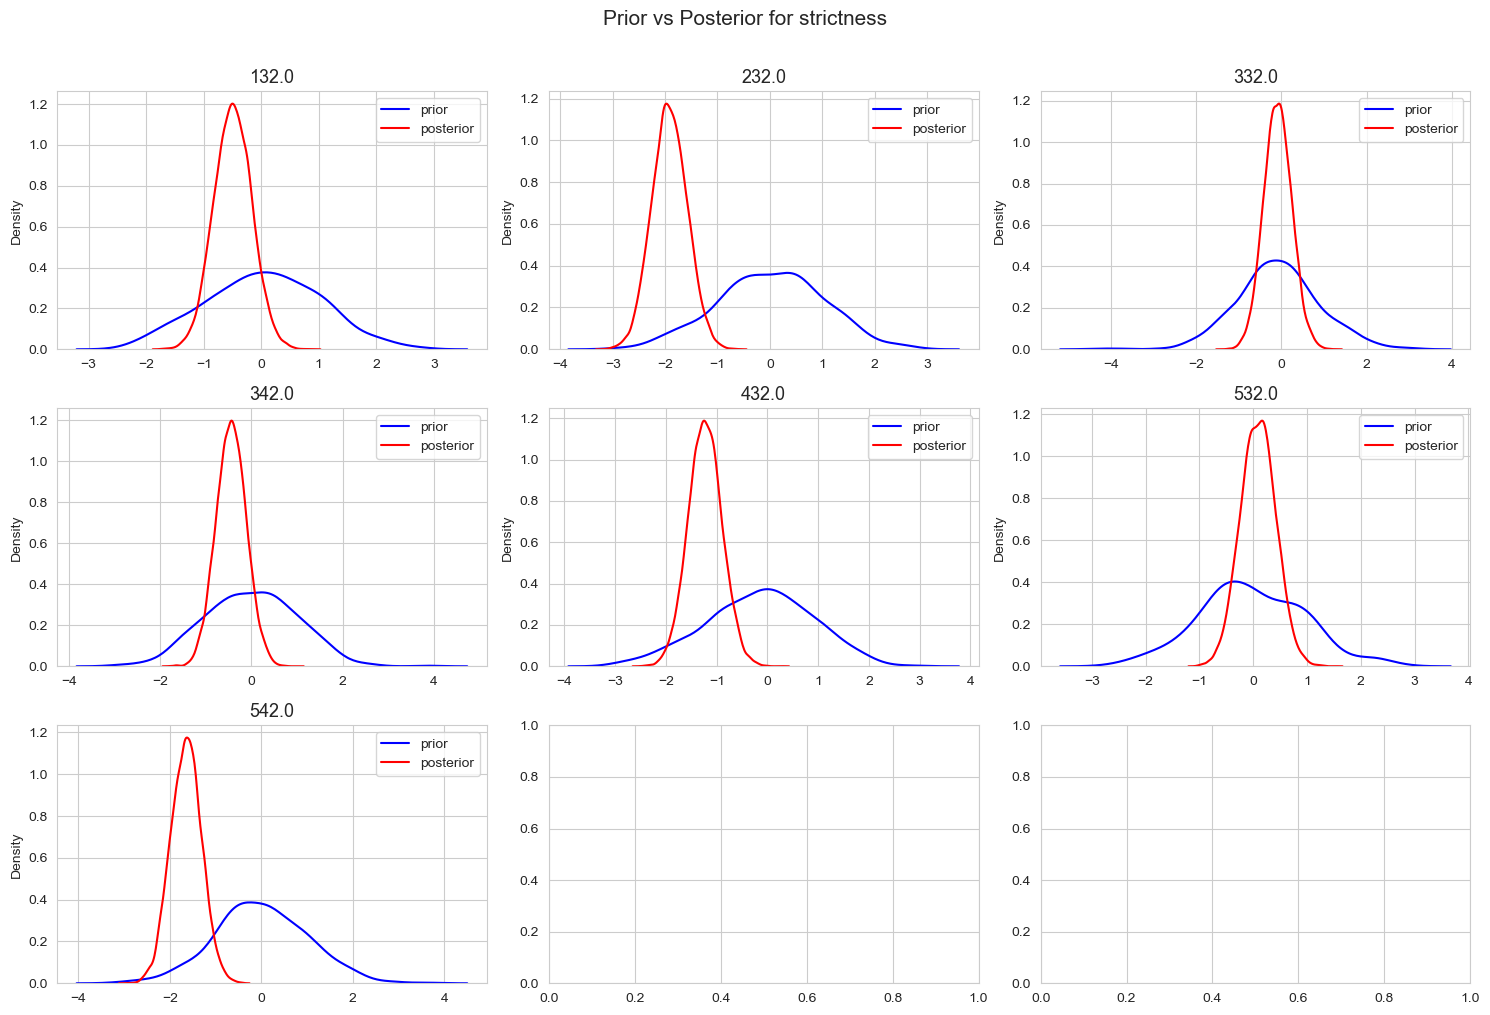

In [778]:
# Posteriors over priors: strictness
fig, axs = plt.subplots(3,3, figsize = (15,10))

for ax,i in zip(axs.flat,range(len(rater_codes))):
    sns.kdeplot(np.ravel(pr.prior['strictness'][:,:,i].values),color = 'blue', ax=ax)
    sns.kdeplot(np.ravel(trace_test.posterior['strictness'][:,:,i].values),color = 'red', ax=ax)
    ax.set_title(rater_codes[i], fontsize = 13)
    ax.legend(['prior','posterior'])
    
plt.suptitle('Prior vs Posterior for strictness', fontsize = 15, y = 1.01)
fig.tight_layout()

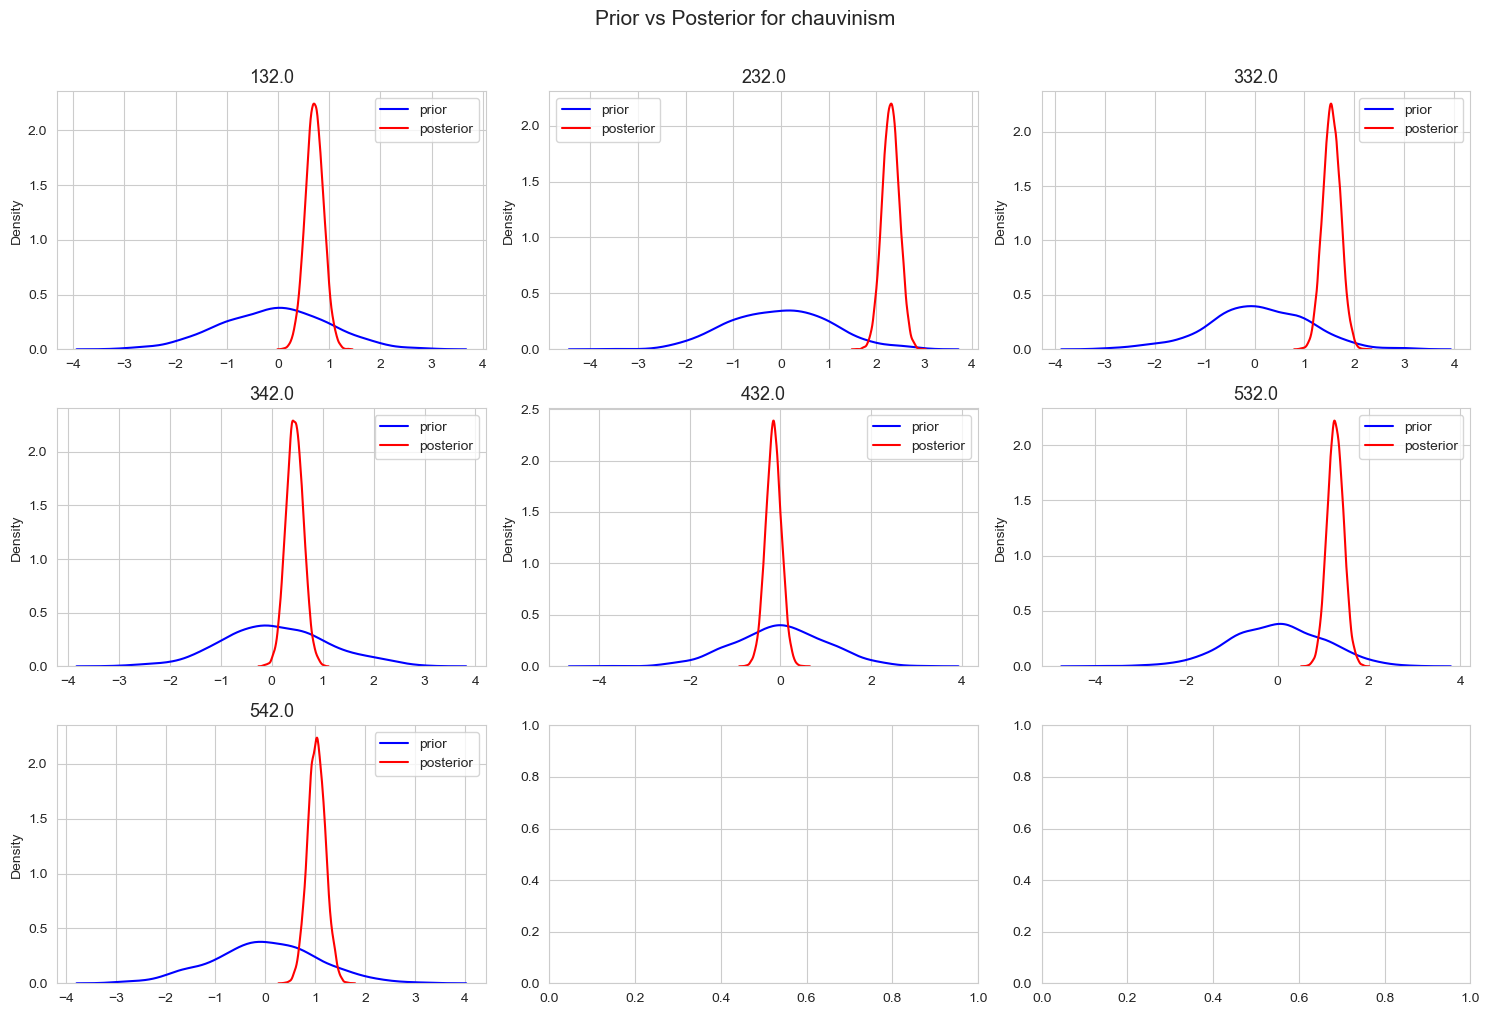

In [779]:
# Posteriors over priors: chauvinism
fig, axs = plt.subplots(3,3, figsize = (15,10))

for ax,i in zip(axs.flat,range(len(rater_codes))):
    sns.kdeplot(np.ravel(pr.prior['chauvinism'][:,:,i].values),color = 'blue', ax=ax)
    sns.kdeplot(np.ravel(trace_test.posterior['chauvinism'][:,:,i].values),color = 'red', ax=ax)
    ax.set_title(rater_codes[i], fontsize = 13)
    ax.legend(['prior','posterior'])
    
plt.suptitle('Prior vs Posterior for chauvinism', fontsize = 15, y = 1.01)
fig.tight_layout()

## Field differences

In [30]:
# get estimates of how much each of the code causes occurs in each field
# this we can then use to get posterior predictive samples from our main model
# this is necessary because there is no parameter for field overall, so we need to know how much of each causes parameter to add in for each field
# because certain combos occur more than others, we don't simply use cause per field, but 'combination of 7 causes' per field

# note: if there is only one group, no need to combine and use 'df_short' instead of 'df_shortall' (which will be the case for the follow-up study)

df_shortall = pd.read_csv(r'C:\Users\conix\Dropbox\aWriting\humanities impact\data\IIH_all_data')
df_shortall = df_shortall.drop(['Unnamed: 0'], axis=1)

causes = ['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing']

# limit to one rater for each group, as all we need is the frequency of codes per paper

df_shortall = df_shortall.loc[df_shortall.rater.isin([521,342])]

# make column with code combo as value

df_shortall['array'] = [str(df_shortall[causes].iloc[i,:].values) for i in range(len(df_shortall))]

# get columns I need
causes_freq = df_shortall[['array','field']].copy()
causes_freq = causes_freq.astype('string')

# combine field and code combo
causes_freq['combined'] = causes_freq['field'] + '_' + (causes_freq["array"])

# one hot encode and stack
causes_freq = pd.get_dummies(data = causes_freq, columns = ['combined'], dtype = int)
causes_freq = causes_freq.iloc[:,2:].stack().reset_index()
causes_freq['level_1'] = causes_freq['level_1'].astype('category')
causes_freq.rename(columns = {0:'observed','level_1':'field_cause_combo'}, inplace = True)

# get categories for the model
group_codes = causes_freq['field_cause_combo'].cat.categories.values
coords = {'g_n': group_codes }

# model the frequencies of the code combos

with pm.Model(coords=coords) as m_causes:
    
    GROUP = pm.MutableData('GROUP',causes_freq['field_cause_combo'].cat.codes.values)
    
    p = pm.Normal('p',0,5, dims = 'g_n')
    y = pm.Bernoulli('y', logit_p = p[GROUP], observed = causes_freq['observed'].values)
    trace_causes = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 980 seconds.


In [31]:
# get the posteriors for each of the code-combos for each of the fields

code_counts = [trace_causes.posterior['g_n'].values[i].split('_')[1] for i in range(len(trace_causes.posterior['g_n'].values))]

h_c = code_counts.count('HIST')
l_c = code_counts.count('LING')
lit_c = code_counts.count('LIT')
p_c = code_counts.count('PHIL')
r_c = code_counts.count('REL')

trace_hist = az.extract_dataset(trace_causes.posterior['p'][:,:,:h_c], combined = True)
trace_ling = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c:h_c+l_c], combined = True)
trace_lit = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c+l_c:h_c+l_c+lit_c], combined = True)
trace_phil = az.extract_dataset(trace_causes.posterior['p'][:,:,h_c+l_c+lit_c:h_c+l_c+lit_c+p_c], combined = True)
trace_rel = az.extract_dataset(trace_causes.posterior['p'][:,:,len(code_counts) - r_c:], combined = True)

traces = [trace_hist, trace_ling, trace_lit, trace_phil, trace_rel]

# choose number of ppc samples
n_ppc = 100000

# samples values from the posteriors of the causes parameters

causes_params = az.extract_dataset(trace_test.posterior['causes'],  combined = True)['causes'][:, np.random.randint(0,trace_test.posterior['causes'].shape[1], size = n_ppc)]
fieldsigma_params = az.extract_dataset(trace_test.posterior['field_sigma'], combined = True)['field_sigma'].values

# loop over the fields, and get values for each field, combining:
# 1) the parameter for that field
# 2) the probabilities of getting certain codes-combos
# 3) the parameters for the causes (multiplied by the code combo)
# then just make the sum of the linear model: sum all causes with the field

ppc_fields = {}
causes_fields = {}

for i in range(5):

    causes_probs = expit(traces[i]['p'][:, np.random.randint(0,traces[i]['p'].shape[1], size=n_ppc)])*5
    causes_probs = causes_probs / causes_probs.sum(axis = 0)
    
    # get code combos for that field
    
    dct = {}
    n_codes = len(traces[i]['g_n'].values)
    for j in range(n_codes):
        dct[j] = np.array(list(map(int,traces[i]['g_n'].values[j].split('_')[2].split('[')[1].split(']')[0].split('.')[:-1])))
        
    # now get an array of the sampled code-combos for that field

    code_combos = [np.random.choice(np.arange(n_codes), p = k) for k in causes_probs.values.T]
    causes_data = np.array([dct[l] for l in code_combos])
    causes_fields[trace_test.posterior['f_n'].values[i]] = causes_data
    
    # now multiply the causes-parameter values by the 1's and 0's that indicate whether they are present
    causes_finished_array = (causes_params * causes_data.T).sum(axis = 0).values
    
    # sum the causes data with the field parameter and store in the dict
    lm = (causes_finished_array + np.random.choice(np.ravel(trace_test.posterior['field'][:,:,i].values),n_ppc, replace = True))
    sigma_sample = np.random.choice(fieldsigma_params[i,:], size = n_ppc, replace=True)
    result = np.random.normal(lm, sigma_sample)
    ppc_fields[trace_test.posterior['f_n'].values[i]] = result
    
    

In [32]:
# run the posterior predictive paper_values for each field through the rating procedure, and see if we get the same number of 1's and 0's
# which strictness values and chauvinism values to use? I'll sample randomly from all raters, and will use a chauvinism-value > 0 for 20% of the papers

n_sample = 69
samples = 1000
chauvinism_posterior = az.extract_dataset(trace_test.posterior['chauvinism'], group = 'posterior', combined = True)
strictness_posterior = az.extract_dataset(trace_test.posterior['strictness'], group = 'posterior', combined = True)


# throw the values for all raters together, and draw randomly from that

chauvinism_merged = np.ravel(chauvinism_posterior['chauvinism'].values)
strictness_merged = np.ravel(strictness_posterior['strictness'].values)

idx_chauv = np.random.randint(0,len(chauvinism_merged), n_sample)
zeros_chauv = np.random.choice([0,1], p = [0.8,0.2], size = n_sample)
idx_strictness = np.random.randint(0,len(strictness_merged), n_sample)

chauv_param = chauvinism_merged[idx_chauv] * zeros_chauv
strictness_param = strictness_merged[idx_strictness]

binary_results = {}

for i in trace_test.posterior['f_n'].values:
    s = []
    for j in range(samples):
        vals = np.random.choice(ppc_fields[i], size = n_sample, replace = True) + strictness_param + chauv_param
        s.append(np.random.binomial(1, p = expit(vals)))
    binary_results[i] = np.array(s)

# fig, ax = plt.subplots(figsize)

# for i in trace_test.posterior['f_n'].values:
    
    

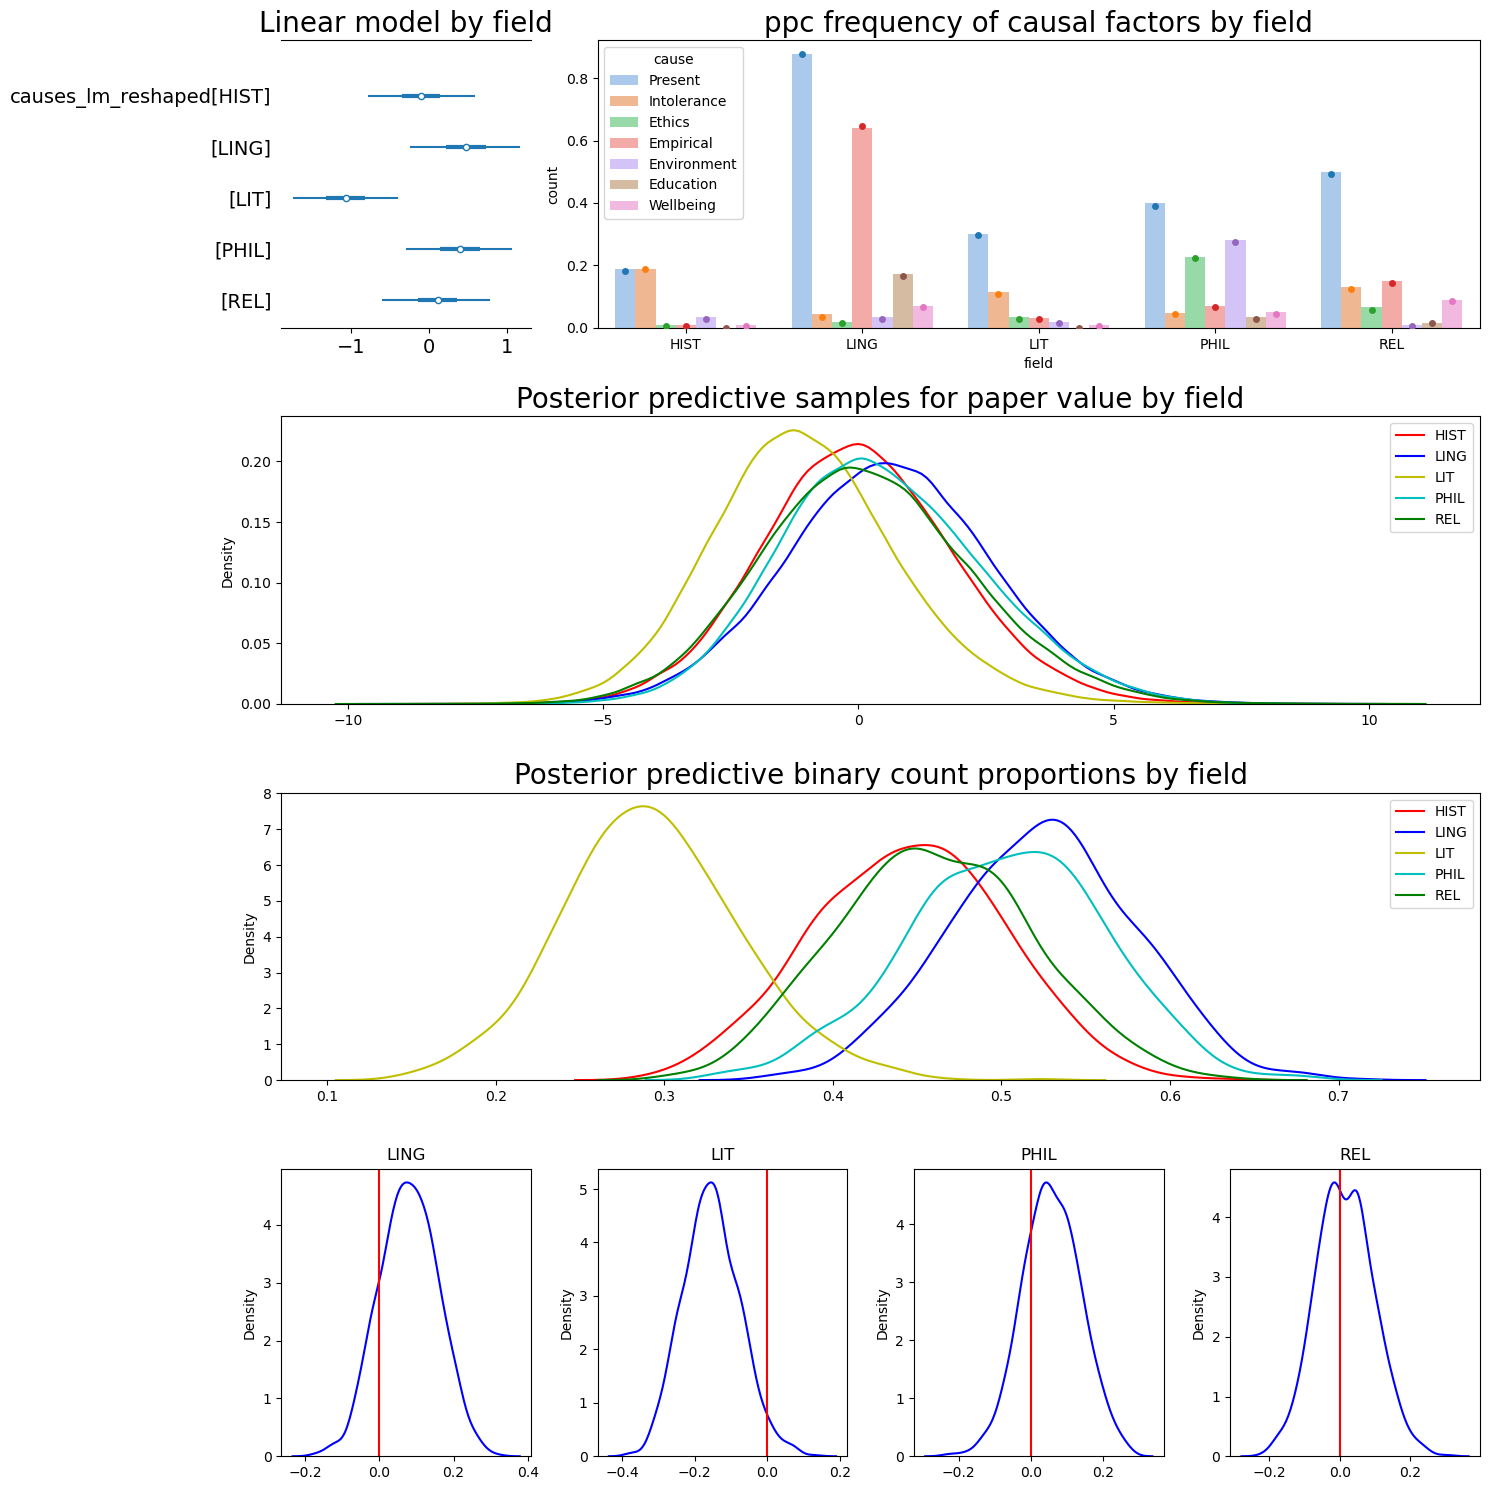

In [33]:
# estimates for the fields averaged over papers
fig, ax = plt.subplot_mosaic('ABBB;CCCC;DDDD;EFGH', figsize = (15,15))

# plot the linear model by field, i.e. just sum the parameters

az.plot_forest(trace_test.posterior['causes_lm_reshaped'].mean(dim = ['b_n']), combined = True, ax=ax["A"])
ax["A"].set_title('Linear model by field', fontsize = 20)

# plot the ppc frequencies for the causes by field. We stored the causes frequencies in the precious cell in 'causes_fields'
# first create df with the counts

causes_counts = pd.DataFrame([causes_fields[i].sum(axis = 0) for i in trace_test.posterior['f_n'].values],
                             columns = causes,
                             index = trace_test.posterior['f_n'].values)


sample_counts = df_shortall[causes + ['field']].groupby('field').sum() / len(df_shortall) * 5

melted = (causes_counts / n_ppc).stack().reset_index() 
melted.rename(columns = {'level_0':'field','level_1':'cause',0:'count'}, inplace=True)

melted2 = (sample_counts).stack().reset_index() 
melted2.rename(columns = {'level_0':'field','level_1':'cause',0:'count'}, inplace=True)

sns.barplot(data = melted, x = 'field', y = 'count', hue = 'cause', palette = 'pastel', ax=ax['B'])
sns.stripplot(data = melted2, x = 'field',y = 'count', hue = 'cause',  legend = False,ax=ax['B'], dodge = True)

ax['B'].set_title('ppc frequency of causal factors by field', fontsize = 20)

# plot the ppc samples by field. This comes from combining m_causes and the main model

colors = ['r','b','y','c','g']

c = 0

for i in trace_test.posterior['f_n'].values:
    sns.kdeplot(ppc_fields[i], color = colors[c],ax=ax['C'])
    c+=1
ax['C'].legend(trace_test.posterior['f_n'].values)
ax['C'].set_title('Posterior predictive samples for paper value by field', fontsize = 20)

c = 0

for i in trace_test.posterior['f_n'].values:
    sns.kdeplot(binary_results[i].mean(axis = 1), color = colors[c],ax=ax['D'])
    c+=1
ax['D'].legend(trace_test.posterior['f_n'].values)
ax['D'].set_title('Posterior predictive binary count proportions by field', fontsize = 20)

HIST = binary_results['HIST'].mean(axis = 1)

c = 0
for i,j in zip(trace_test.posterior['f_n'].values[1:], ['E','F','G','H']):
    sns.kdeplot(binary_results[i].mean(axis = 1) - HIST, color = 'b',ax=ax[j])

    ax[j].set_title(i)
    ax[j].axvline(0, color = 'r')
fig.tight_layout()
plt.show()

## Sanity check: does our model know which abstracts should get high and low scores

In [34]:
# check which abstracts are the highest and lowest scoring ones for ordinal and binary

df[['ordinal','binary']] = df[['ordinal','binary']].astype('int')
df['fieldblock'] = [str(df.field.values[i]) + str(df.block.values[i]) for i in range(len(df))]

ord_top5 = (df[['ordinal','binary','fieldblock']]
             .groupby('fieldblock').sum()
             .sort_values(by = 'ordinal', ascending = False).index[:5])

bin_top5 = (df[['ordinal','binary','fieldblock']]
             .groupby('fieldblock').sum()
             .sort_values(by = 'binary', ascending = False).index[:5])

ord_bottom5 = (df[['ordinal','binary','fieldblock']]
             .groupby('fieldblock').sum()
             .sort_values(by = 'ordinal', ascending = True).index[:5])

bin_bottom5 = (df[['ordinal','binary','fieldblock']]
             .groupby('fieldblock').sum()
             .sort_values(by = 'binary', ascending = True).index[:5])

# get a df with the estimated paper means

paper_means = pd.DataFrame(az.summary(trace_test, var_names = 'paper_value')['mean']).reset_index()
paper_means['fieldblock'] = [i.split(', ')[1].split(']')[0] + i.split('[')[1].split(',')[0] for i in paper_means['index'].values]
paper_means['field'] = [paper_means['index'].values[i].split(', ')[1].split(']')[0] for i in range(len(paper_means))]

# get the estimated means

ord_top5means = paper_means.loc[paper_means['fieldblock'].isin(ord_top5)]['mean'].values
bin_top5means = paper_means.loc[paper_means['fieldblock'].isin(bin_top5)]['mean'].values
ord_bottom5means = paper_means.loc[paper_means['fieldblock'].isin(ord_bottom5)]['mean'].values
bin_bottom5means = paper_means.loc[paper_means['fieldblock'].isin(bin_bottom5)]['mean'].values

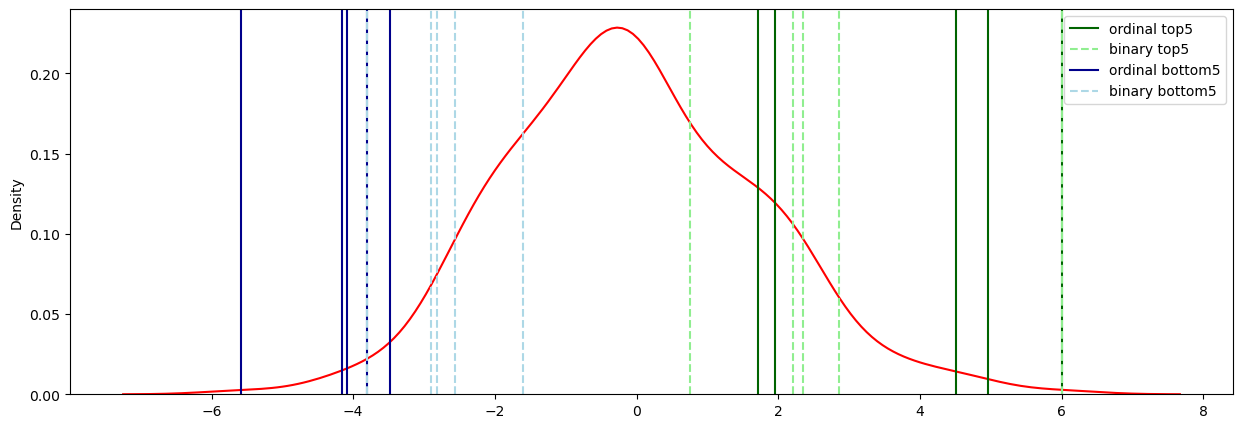

In [35]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize = (15,5))

sns.kdeplot(paper_means['mean'].values, color = 'red', ax=ax)

for i in ord_top5means:
    ax.axvline(i, color = 'darkgreen', alpha = 1)
    
for i in bin_top5means:
    ax.axvline(i, color = 'lightgreen', alpha = 1, ls = '--')
    
for i in ord_bottom5means:
    ax.axvline(i, color = 'darkblue', alpha = 1)
    
for i in bin_bottom5means:
    ax.axvline(i, color = 'lightblue', alpha = 1, ls = '--')

    
ordinal_t = mlines.Line2D([], [], color='darkgreen',  ls='-', label='ordinal top5')
binary_t = mlines.Line2D([], [], color='lightgreen',  ls='--', label='binary top5')
ordinal_b = mlines.Line2D([], [], color='darkblue',  ls='-', label='ordinal bottom5')
binary_b = mlines.Line2D([], [], color='lightblue',  ls='--', label='binary bottom5')

ax.legend(handles=[ordinal_t,binary_t,ordinal_b,binary_b])